<font size = 6> Hidden Markov Models Applied To Intraday Momentum Trading With Side Information - Clean Data</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Dec 12, 2022</div></font>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import pytz

from datetime import datetime, timedelta
from time import time, strftime, localtime
from collections import OrderedDict
from itertools import islice
from scipy.stats import norm
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from hmmlearn.hmm import GaussianHMM as HMM
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import  DateFormatter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
input_file = "D:/Software_Workspace/temp/TradeData.csv"
output_path = "D:/Software_Workspace/temp/TradeData/"
data_path = "D:/Software_Workspace/temp/TradeData/"

# Clean Data

## Trade Dataset Overview

In [ ]:
pd.read_csv(input_file, nrows = 5)

,Time,Exchange,Symbol,Sale_Condition,Trade_Volume,Trade_Price,Trade_Stop_Stock_Indicator,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Source_of_Trade,Trade_Reporting_Facility,Participant_Timestamp,Trade_Reporting_Facility_TRF_Timestamp,Trade_Through_Exempt_Indicator,Date,YearMonth
0,2020-12-01 04:00:00.068 -0500,P,AAPL,@ T,5354,120.84,NaN,0,1348,1,N,,40000067830272,NaN,1,2020-11-30,202012
1,2020-12-01 04:00:00.101 -0500,P,AAPL,@ TI,84,120.84,NaN,0,1351,2,N,,40000100800256,NaN,0,2020-11-30,202012
2,2020-12-01 04:00:00.273 -0500,P,AAPL,@ TI,23,120.84,NaN,0,1356,3,N,,40000273246976,NaN,0,2020-11-30,202012
3,2020-12-01 04:00:00.273 -0500,P,AAPL,@ T,137,120.81,NaN,0,1357,4,N,,40000273246976,NaN,0,2020-11-30,202012
4,2020-12-01 04:00:00.296 -0500,P,AAPL,@FTI,29,120.81,NaN,0,1358,5,N,,40000296556288,NaN,1,2020-11-30,202012


## Get Date & Symbol Information

In [ ]:
%%time
date_symbol = pd.read_csv(input_file, usecols = ["Date", "Symbol"], chunksize = 5000000, iterator = True)
date_count = {}
symbol_count = {}
load = []
for chunk in date_symbol:
    temp = pd.DataFrame(chunk.value_counts())
    for i, stock_date in enumerate(list(temp.index)):
        date_count[stock_date] = date_count.setdefault(stock_date, 0) + int(temp.iloc[i])
        symbol_count[stock_date[0]][1] = symbol_count.setdefault(stock_date[0], [0, 0])[1] + int(temp.iloc[i])
        if stock_date not in load:
            load.append(stock_date)
            symbol_count[stock_date[0]][0] += 1

CPU times: total: 2min 49s
Wall time: 2min 49s


In [ ]:
symbol_count

{'AAPL': [253, 151193183], 'SPY': [113, 102769830]}

In [ ]:
sort_date_count = OrderedDict()
for date_temp in sorted(date_count.keys(), key = lambda x: (x[1], x[0])):
    sort_date_count[date_temp] =  date_count[date_temp]
OrderedDict(islice(sort_date_count.items(), 0, 20))

OrderedDict([(('AAPL', '2020-01-01'), 283504),
             (('SPY', '2020-01-01'), 304906),
             (('AAPL', '2020-01-02'), 280948),
             (('SPY', '2020-01-02'), 358514),
             (('AAPL', '2020-01-05'), 242878),
             (('SPY', '2020-01-05'), 255781),
             (('AAPL', '2020-01-06'), 227883),
             (('SPY', '2020-01-06'), 226083),
             (('AAPL', '2020-01-07'), 261788),
             (('SPY', '2020-01-07'), 340023),
             (('AAPL', '2020-01-08'), 328771),
             (('SPY', '2020-01-08'), 242176),
             (('AAPL', '2020-01-09'), 294858),
             (('SPY', '2020-01-09'), 236234),
             (('AAPL', '2020-01-12'), 254966),
             (('SPY', '2020-01-12'), 217449),
             (('AAPL', '2020-01-13'), 342969),
             (('SPY', '2020-01-13'), 331329),
             (('AAPL', '2020-01-14'), 264917),
             (('SPY', '2020-01-14'), 293456)])

## Split Dataset by Date & Symbol

In [ ]:
def export_trade_data(input_file, output_path, range_tuple, item_list = sort_date_count, chunksize = 1000000):
    temp = OrderedDict(islice(item_list.items(), range_tuple[0], range_tuple[1]))
    if temp == OrderedDict():
        print("No data to process!")
        return
    for key, value in temp.items():
        data_iterator = pd.read_csv(path_in, chunksize = chunksize, iterator = True, low_memory = False)
        target_data = pd.DataFrame([])
        print(strftime('%Y-%m-%d %H:%M:%S',localtime(time())) + " " + key[1] + "_" + key[0] + " Begins!")
        for chunk in data_iterator:
            target_data = pd.concat([target_data, chunk[(chunk["Date"] == key[1]) & (chunk["Symbol"] == key[0])]])
            if target_data.shape[0] == value:
                print(strftime('%Y-%m-%d %H:%M:%S',localtime(time())) + " " + key[1] + "_" + key[0] + " Verified! - %d Elements." % value)
                break
        target_data.index = target_data["Time"]
        target_data = target_data.drop(columns = ["Time"]).sort_index()
        target_data.to_csv(path_out + key[1] + "_" + key[0] + "_Trade.csv")
        print(strftime('%Y-%m-%d %H:%M:%S', localtime(time())) + " " + key[1] + "_" + key[0] + " Finishs!")

In [ ]:
# export_trade_data(input_file, output_path, (89,200))

2022-09-24 02:21:20 2020-03-22_AAPL Begins!
2022-09-24 02:29:42 2020-03-22_AAPL Verified! - 838675 Elements.
2022-09-24 02:29:46 2020-03-22_AAPL Finishs!
2022-09-24 02:29:46 2020-03-22_SPY Begins!
2022-09-24 02:38:27 2020-03-22_SPY Verified! - 11664042 Elements.
2022-09-24 02:39:19 2020-03-22_SPY Finishs!
2022-09-24 02:39:20 2020-03-23_AAPL Begins!
2022-09-24 02:47:40 2020-03-23_AAPL Verified! - 692514 Elements.
2022-09-24 02:47:43 2020-03-23_AAPL Finishs!
2022-09-24 02:47:43 2020-03-23_SPY Begins!
2022-09-24 02:55:36 2020-03-23_SPY Verified! - 3251626 Elements.
2022-09-24 02:55:51 2020-03-23_SPY Finishs!
2022-09-24 02:55:51 2020-03-24_AAPL Begins!
2022-09-24 02:59:28 2020-03-24_AAPL Verified! - 755758 Elements.
2022-09-24 02:59:31 2020-03-24_AAPL Finishs!
2022-09-24 02:59:31 2020-03-24_SPY Begins!
2022-09-24 03:02:58 2020-03-24_SPY Verified! - 2166634 Elements.
2022-09-24 03:03:07 2020-03-24_SPY Finishs!
2022-09-24 03:03:07 2020-03-25_AAPL Begins!
2022-09-24 03:08:08 2020-03-25_AAPL V

In [ ]:
# export_trade_data(input_file, output_path, (250,370))

2022-09-24 17:07:30 2020-08-11_SPY Begins!
2022-09-24 17:08:58 2020-08-11_SPY Verified! - 312603 Elements.
2022-09-24 17:09:00 2020-08-11_SPY Finishs!
2022-09-24 17:09:00 2020-08-12_AAPL Begins!
2022-09-24 17:12:16 2020-08-12_AAPL Verified! - 633357 Elements.
2022-09-24 17:12:18 2020-08-12_AAPL Finishs!
2022-09-24 17:12:18 2020-08-12_SPY Begins!
2022-09-24 17:13:51 2020-08-12_SPY Verified! - 278303 Elements.
2022-09-24 17:13:53 2020-08-12_SPY Finishs!
2022-09-24 17:13:53 2020-08-13_AAPL Begins!
2022-09-24 17:17:25 2020-08-13_AAPL Verified! - 538672 Elements.
2022-09-24 17:17:27 2020-08-13_AAPL Finishs!
2022-09-24 17:17:27 2020-08-13_SPY Begins!
2022-09-24 17:19:09 2020-08-13_SPY Verified! - 249694 Elements.
2022-09-24 17:19:10 2020-08-13_SPY Finishs!
2022-09-24 17:19:10 2020-08-16_AAPL Begins!
2022-09-24 17:22:57 2020-08-16_AAPL Verified! - 435145 Elements.
2022-09-24 17:22:59 2020-08-16_AAPL Finishs!
2022-09-24 17:22:59 2020-08-16_SPY Begins!
2022-09-24 17:24:48 2020-08-16_SPY Verifie

## Export Data

In [ ]:
def read_split_csv(path):
    df = pd.read_csv(path, low_memory = False)
    df["Time"] = df["Time"].apply(lambda x: datetime.strptime(x[:23],"%Y-%m-%d %H:%M:%S.%f"))
    return df

def get_seconds(timedelta):
    return timedelta.seconds + timedelta.microseconds*(1.0e-6)

def dynamic_filter(df):
    early_start = datetime(df["Time"][0].year, df["Time"][0].month, df["Time"][0].day, 4, 0, 0)
    start = datetime(df["Time"][0].year, df["Time"][0].month, df["Time"][0].day, 9, 30, 0)
    end = datetime(df["Time"][0].year, df["Time"][0].month, df["Time"][0].day, 16, 0, 0)
    late_end =  datetime(df["Time"][0].year, df["Time"][0].month, df["Time"][0].day, 20, 0, 0)
    return df[(start <= df["Time"]) & (df["Time"] < end)], early_start, start, end, late_end

def get_time_groups(df, attr_list, freq, if_filter = True):
    interval = {}
    interval["1s"] = timedelta(seconds=1).seconds
    interval["1min"] = timedelta(minutes=1).seconds
    interval["5min"] = timedelta(minutes=5).seconds
    interval["30min"] = timedelta(minutes=30).seconds
    if if_filter:
        filter_result = dynamic_filter(df)
        df = filter_result[0]
        day_start = filter_result[2]
    else:
        day_start = filter_result[1]
    df = df.rename(columns = {"Time": "To_Time"}, inplace = False)
    return df[attr_list].groupby(by=df["To_Time"].apply(
        lambda x: pd.to_timedelta(((int(get_seconds(x - day_start)) // interval[freq]) + 1) * interval[freq], unit="seconds") + day_start), as_index=True)

def get_prices(time_groups):
    df = pd.DataFrame([])
    df["High"], df["Low"] = time_groups.max(), time_groups.min()
    df["Open"], df["Close"] = time_groups.head(1).to_numpy(), time_groups.tail(1).to_numpy()
    return df

def get_all_prices(path, freq, if_filter = True):
    AAPL_path = path + "AAPL/"
    AAPL_file_path = os.listdir(AAPL_path)
    df = pd.DataFrame([])
    for file in AAPL_file_path:
        read_temp = read_split_csv(AAPL_path + file)
        read_temp = get_prices(get_time_groups(read_temp, ["Trade_Price"], freq, if_filter = if_filter))
        df = pd.concat([df, read_temp])
        print(file + " Done!")
    df.to_csv(path + freq + "_prices.csv")
    return df

In [ ]:
%%time
# all_price_1min = get_all_prices(output_path, "1min")
# all_price_1min.to_csv(output_path + "1min_prices.csv")

# CPU times: total: 1h 11min 41s
# Wall time: 1h 11min 45s

In [ ]:
%%time
# all_price_30min = get_all_prices(output_path, "30min")
# all_price_30min.to_csv(output_path + "30min_prices.csv")

# CPU times: total: 1h 20min 18s
# Wall time: 1h 20min 27s

## Analyze Trade Data - Take 2020-01-09 as an example

In [ ]:
analyze = pd.read_csv(output_path + "2020-01-08_AAPL_Trade.csv", low_memory = False)
analyze["Time"] = analyze["Time"].apply(lambda x: datetime.strptime(x[:23],"%Y-%m-%d %H:%M:%S.%f"))
analyze.head(4)
analyze.tail(4)

,Time,Exchange,Symbol,Sale_Condition,Trade_Volume,Trade_Price,Trade_Stop_Stock_Indicator,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Source_of_Trade,Trade_Reporting_Facility,Participant_Timestamp,Trade_Reporting_Facility_TRF_Timestamp,Trade_Through_Exempt_Indicator,Date,YearMonth
0,2020-01-09 04:00:00.062,P,AAPL,@ T,600,305.19,NaN,0,1188,1,N,,40000062338048,NaN,1,2020-01-08,202001
1,2020-01-09 04:00:00.100,P,AAPL,@FTI,24,305.19,NaN,0,1190,2,N,,40000100432896,NaN,1,2020-01-08,202001
2,2020-01-09 04:00:00.327,P,AAPL,@FTI,1,305.00,NaN,0,1191,3,N,,40000326615808,NaN,1,2020-01-08,202001
3,2020-01-09 04:00:00.359,Q,AAPL,@FTI,1,305.02,NaN,0,1192,1,N,,40000359001405,NaN,1,2020-01-08,202001


,Time,Exchange,Symbol,Sale_Condition,Trade_Volume,Trade_Price,Trade_Stop_Stock_Indicator,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Source_of_Trade,Trade_Reporting_Facility,Participant_Timestamp,Trade_Reporting_Facility_TRF_Timestamp,Trade_Through_Exempt_Indicator,Date,YearMonth
328767,2020-01-09 19:59:55.811,P,AAPL,@ TI,10,310.4,NaN,0,3630464,33011,N,,195955811102464,NaN,0,2020-01-08,202001
328768,2020-01-09 19:59:55.811,P,AAPL,@ T,591,310.4,NaN,0,3630465,33012,N,,195955811102464,NaN,0,2020-01-08,202001
328769,2020-01-09 19:59:59.703,K,AAPL,@ TI,5,310.4,NaN,0,3630468,23417,N,,195959703619000,NaN,1,2020-01-08,202001
328770,2020-01-09 19:59:59.704,Q,AAPL,@FTI,95,310.4,NaN,0,3630469,75725,N,,195959704174556,NaN,1,2020-01-08,202001


### Exchange



| CODE  | Description          
| ----  | ---- |
|  A    |NYSE American, LLC (NYSE American)
|  B    |NASDAQ OMX BX, Inc. (NASDAQ OMX BX)
|  C    |NYSE National, Inc (NYSE National)
|  D    |FINRA Alternative Display Facility (ADF)
|  I    |International Securities Exchange, LLC (ISE)
|  J    |Cboe EDGA Exchange (Cboe EDGA)
|  K    |Cboe EDGX Exchange (Cboe EDGX)
|  L    |Long-Term Stock Exchange, Inc. (LTSE)
|  M    |Chicago Stock Exchange, Inc. (NYSE Chicago)
|  N    |New York Stock Exchange, LLC (NYSE)
|  P    |NYSE Arca, Inc. (NYSE Arca)
|  S    |Consolidated Tape System (CTS)
|  T    |NASDAQ Stock Market, LLC (in Tape A, B securities) (NASDAQ)
|  Q    |NASDAQ Stock Exchange, LLC (in Tape C securities)
|  V    |The Investors’ Exchange, LLC (IEX)
|  W    |Chicago Broad Options Exchange, Inc.(CBSX)
|  X    |NASDAQ OMX PSX, Inc. (NASDAQ OMX PSX)
|  Y    |Cboe BYX Exchange, Inc (Cboe BYX)
|  Z    |Cboe BZX Exchange, Inc (Cboe BZX)

<font size = 3><div style="text-align: right">Reference - Daily TAQ Client Specification v3.2 (Page61)</div></font>

In [ ]:
analyze["Exchange"].value_counts(ascending = False)

D    128739
Q     75725
Z     40987
P     33012
K     23417
N      9107
V      5101
J      3494
B      3022
Y      2868
X      2126
C       678
A       409
M        86
Name: Exchange, dtype: int64

### Date & Time

#### Trade Schedule

In [ ]:
mcal.get_calendar('NYSE').schedule(start_date='2020-01-01', end_date='2020-12-31', start="pre", end="post").applymap(lambda x: x.astimezone(pytz.timezone(nyse.tz.zone)))

,pre,market_open,market_close,post
2020-01-02,2020-01-02 04:00:00-05:00,2020-01-02 09:30:00-05:00,2020-01-02 16:00:00-05:00,2020-01-02 20:00:00-05:00
2020-01-03,2020-01-03 04:00:00-05:00,2020-01-03 09:30:00-05:00,2020-01-03 16:00:00-05:00,2020-01-03 20:00:00-05:00
2020-01-06,2020-01-06 04:00:00-05:00,2020-01-06 09:30:00-05:00,2020-01-06 16:00:00-05:00,2020-01-06 20:00:00-05:00
2020-01-07,2020-01-07 04:00:00-05:00,2020-01-07 09:30:00-05:00,2020-01-07 16:00:00-05:00,2020-01-07 20:00:00-05:00
2020-01-08,2020-01-08 04:00:00-05:00,2020-01-08 09:30:00-05:00,2020-01-08 16:00:00-05:00,2020-01-08 20:00:00-05:00
...,...,...,...,...
2020-12-24,2020-12-24 04:00:00-05:00,2020-12-24 09:30:00-05:00,2020-12-24 13:00:00-05:00,2020-12-24 13:00:00-05:00
2020-12-28,2020-12-28 04:00:00-05:00,2020-12-28 09:30:00-05:00,2020-12-28 16:00:00-05:00,2020-12-28 20:00:00-05:00
2020-12-29,2020-12-29 04:00:00-05:00,2020-12-29 09:30:00-05:00,2020-12-29 16:00:00-05:00,2020-12-29 20:00:00-05:00
2020-12-30,2020-12-30 04:00:00-05:00,2020-12-30 09:30:00-05:00,2020-12-30 16:00:00-05:00,2020-12-30 20:00:00-05:00


[Pre-Market Trading](https://www.investopedia.com/terms/p/premarket.asp)</br>
[What Is After-Hours Trading?](https://www.investopedia.com/terms/a/afterhourstrading.asp)</br>
[Pre-Market and After-Hours Trading](https://www.investopedia.com/ask/answers/06/preaftermarket.asp)</br>
[Trading in the Pre- and Post-Market Sessions](https://www.investopedia.com/financial-edge/1112/trading-in-the-pre--and-post-market-sessions.aspx)

#### Trade Volume

In [ ]:
def get_seconds(timedelta):
    return timedelta.seconds + timedelta.microseconds*(1.0e-6)

def get_time_groups(df, attr_list, freq, day_start =  datetime.strptime("2020-01-09 04:00","%Y-%m-%d %H:%M")):
    interval = {}
    interval["1s"] = timedelta(seconds=1).seconds
    interval["1min"] = timedelta(minutes=1).seconds
    interval["5min"] = timedelta(minutes=5).seconds
    interval["30min"] = timedelta(minutes=30).seconds
    df = df.rename(columns = {"Time": "To_Time"}, inplace = False)
    return df[attr_list].groupby(by=df["To_Time"].apply(
        lambda x: pd.to_timedelta(((int(get_seconds(x - day_start)) // interval[freq]) + 1) * interval[freq], unit="seconds") + day_start), as_index=True)

In [ ]:
trade_volume_1min = get_time_groups(analyze,["Trade_Volume"],"1min").sum()
trade_volume_30min = get_time_groups(analyze,["Trade_Volume"],"30min").sum()

In [ ]:
def trade_volume_plot(df):
    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(1, 1, 1)
    fmt_x = DateFormatter('%H:%M:%S')
    fmt_y = lambda y, pos: '{:.0E}'.format(y, pos)
    my_x_ticks = trade_volume_30min.index[::2]
    ax1.plot(df.index, df, ls=":", lw=5, marker="s", ms=10, mfc="r", zorder=2)
    ax1.plot([datetime.strptime("2020-01-09 09:30","%Y-%m-%d %H:%M")] * 2, np.linspace(-500, df.max()+50000, 2), lw=5,c="orange",zorder=1)
    ax1.plot([datetime.strptime("2020-01-09 16:00","%Y-%m-%d %H:%M")] * 2, np.linspace(-500, df.max()+50000, 2), lw=5,c="orange",zorder=1)

    plt.xticks(my_x_ticks, fontsize=18, rotation = 30)
    plt.xticks(fontsize=18, rotation = 30)
    plt.yticks(fontsize=18, rotation = 30)

    ax1.xaxis.set_major_formatter(fmt_x)
    ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt_y))
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Trade Volume", fontsize=18)
    plt.title("Trade Volume in different time (2020-01-09)", fontsize=22)

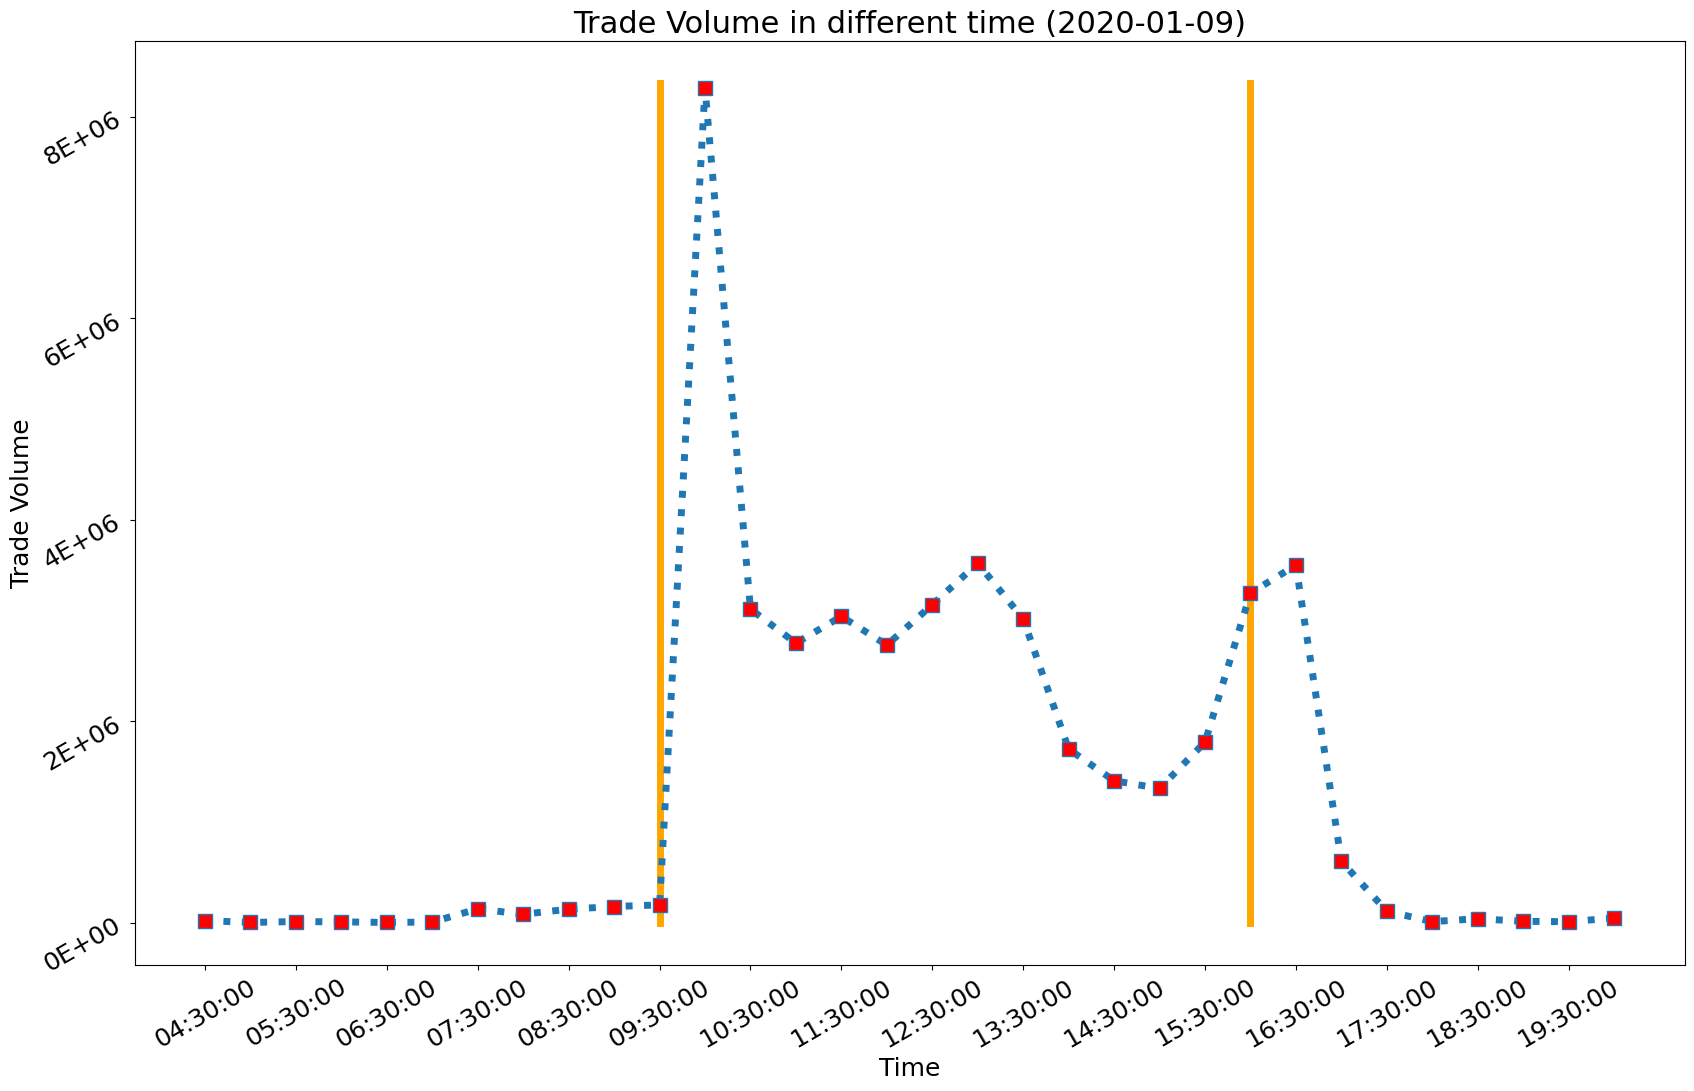

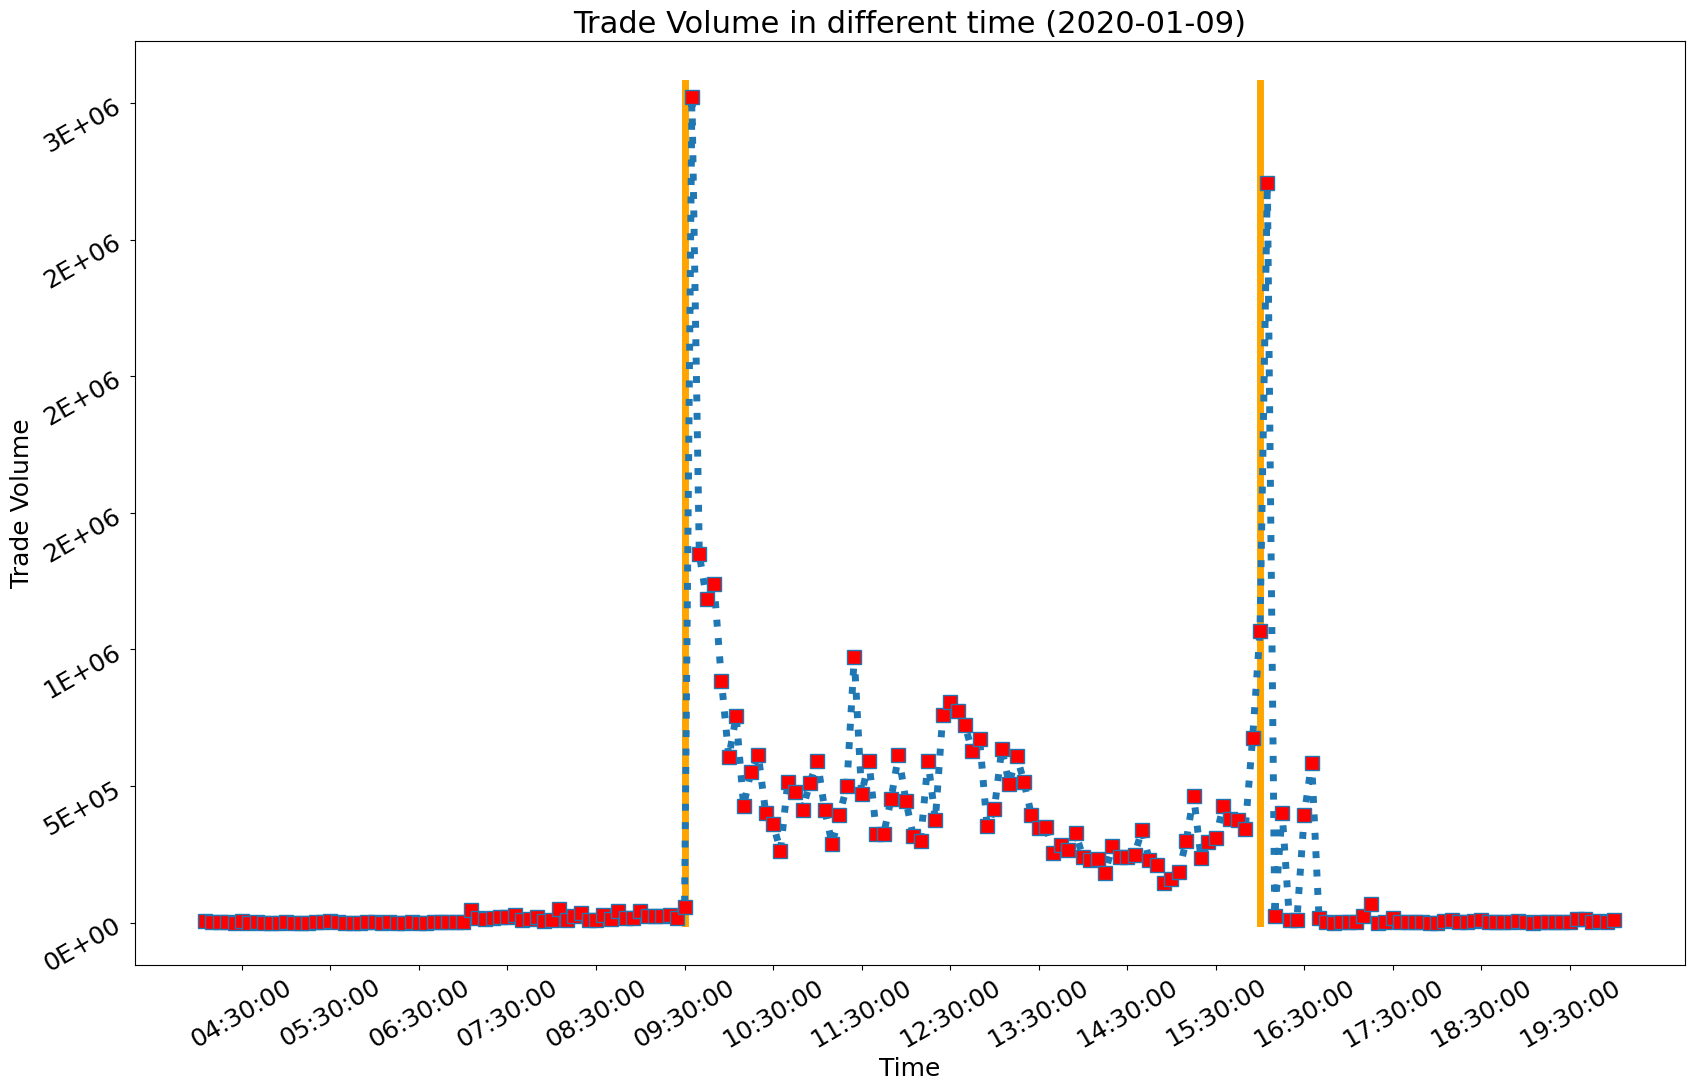

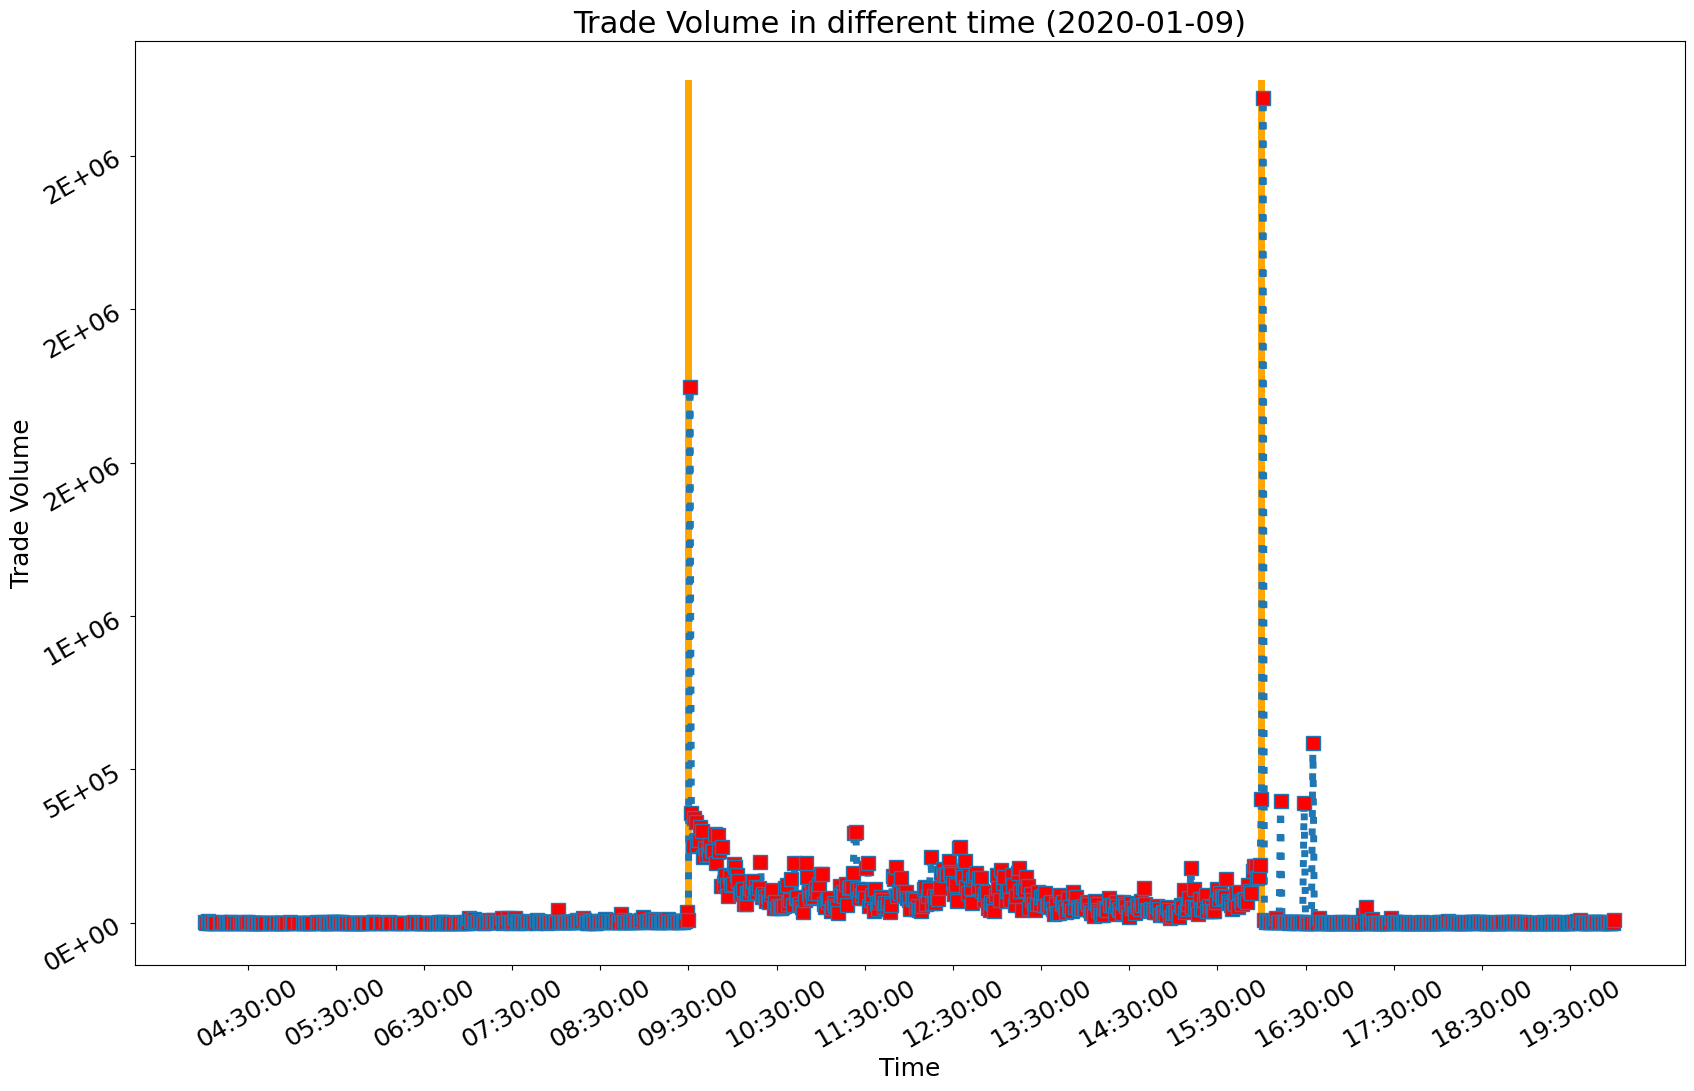

In [ ]:
trade_volume_plot(trade_volume_1min)
trade_volume_plot(trade_volume_30min)

#### Trade Price

In [ ]:
def get_prices(time_groups):
    df = pd.DataFrame([])
    df["High"], df["Low"] = time_groups.max(), time_groups.min()
    df["Open"], df["Close"] = time_groups.head(1).to_numpy(), time_groups.tail(1).to_numpy()
    return df

In [ ]:
price_1min = get_prices(get_time_groups(analyze,["Trade_Price"],"1min"))
price_30min = get_prices(get_time_groups(analyze,["Trade_Price"],"30min"))

In [ ]:
def price_plot(df):
    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(1, 1, 1)
    fmt_x = DateFormatter('%H:%M:%S')
    fmt_y = lambda y, pos: '{:.1f}'.format(y, pos)
    my_x_ticks = trade_volume_30min.index[::2]
    ax1.plot(df.index, df["High"],  marker="s", ms=2, mfc="r", zorder=2, label = "High")
    ax1.plot(df.index, df["Low"],  marker="s", ms=2, mfc="r", zorder=2, label = "Low")
    ax1.plot(df.index, df["Open"],  marker="s", ms=2, mfc="r", zorder=2, label = "Open")
    ax1.plot(df.index, df["Close"], marker="s", ms=2, mfc="r", zorder=3, label = "Close", c="k")
    ax1.plot([datetime.strptime("2020-01-09 09:30","%Y-%m-%d %H:%M")] * 2, np.linspace(df["Low"].min()-5, df["High"].max()+5, 2), lw=3,c="orange",zorder=1)
    ax1.plot([datetime.strptime("2020-01-09 16:00","%Y-%m-%d %H:%M")] * 2, np.linspace(df["Low"].min()-5, df["High"].max()+5, 2), lw=3,c="orange",zorder=1)

    plt.xticks(my_x_ticks, fontsize=18, rotation = 30)
    plt.xticks(fontsize=18, rotation = 30)
    plt.yticks(fontsize=18, rotation = 30)
    plt.ylim(df["Low"].mean()-5, df["High"].mean()+5)

    ax1.xaxis.set_major_formatter(fmt_x)
    ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt_y))
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Stock Price", fontsize=18)
    plt.title("Stock Price in different time (2020-01-09)", fontsize=22)
    plt.legend(fontsize=18)

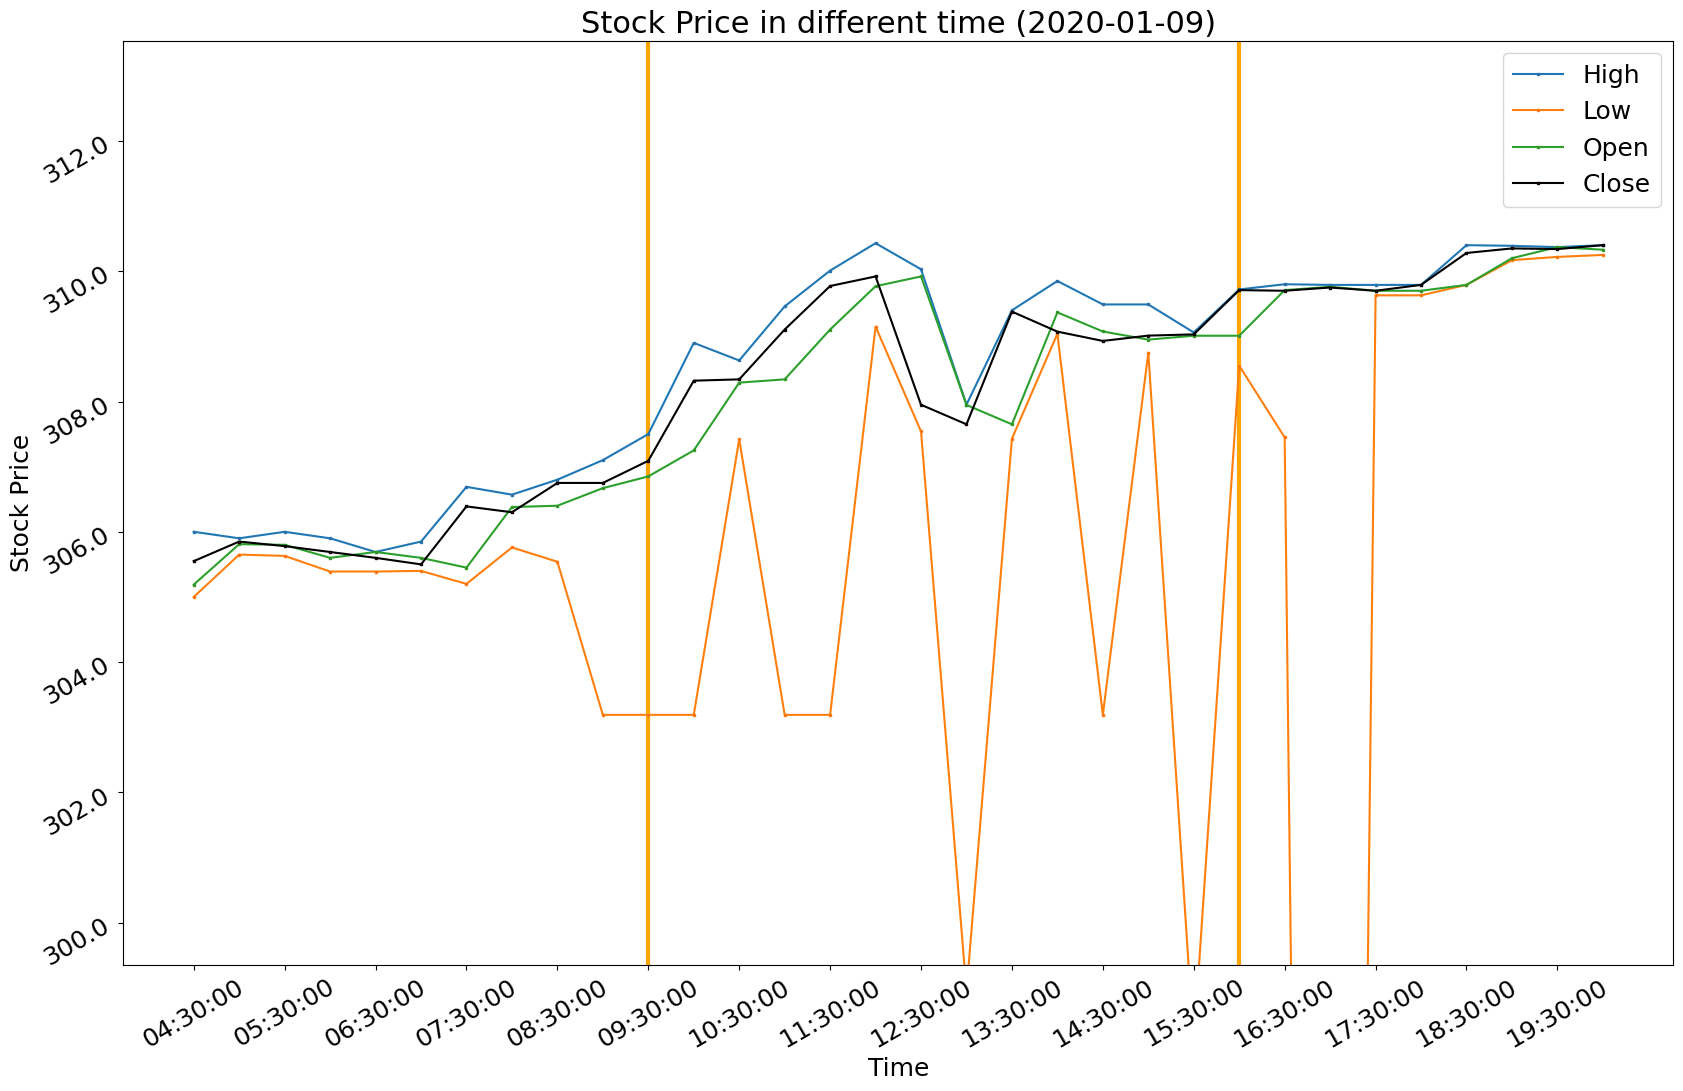

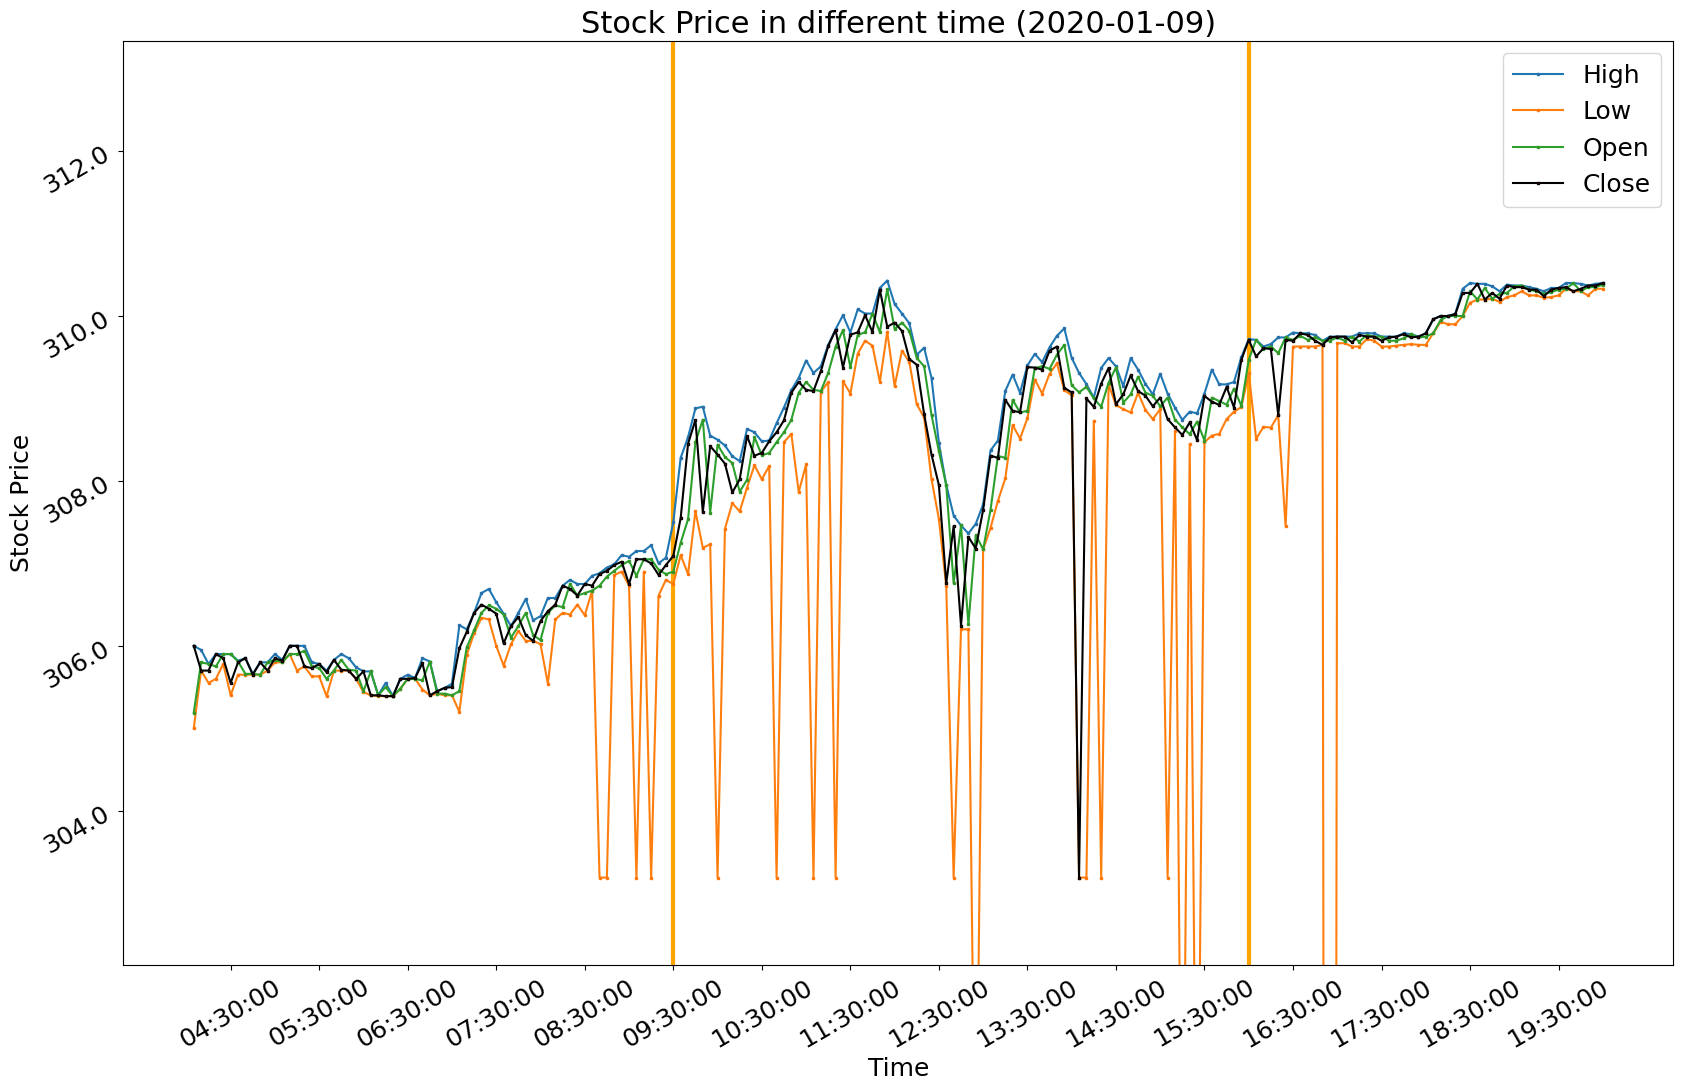

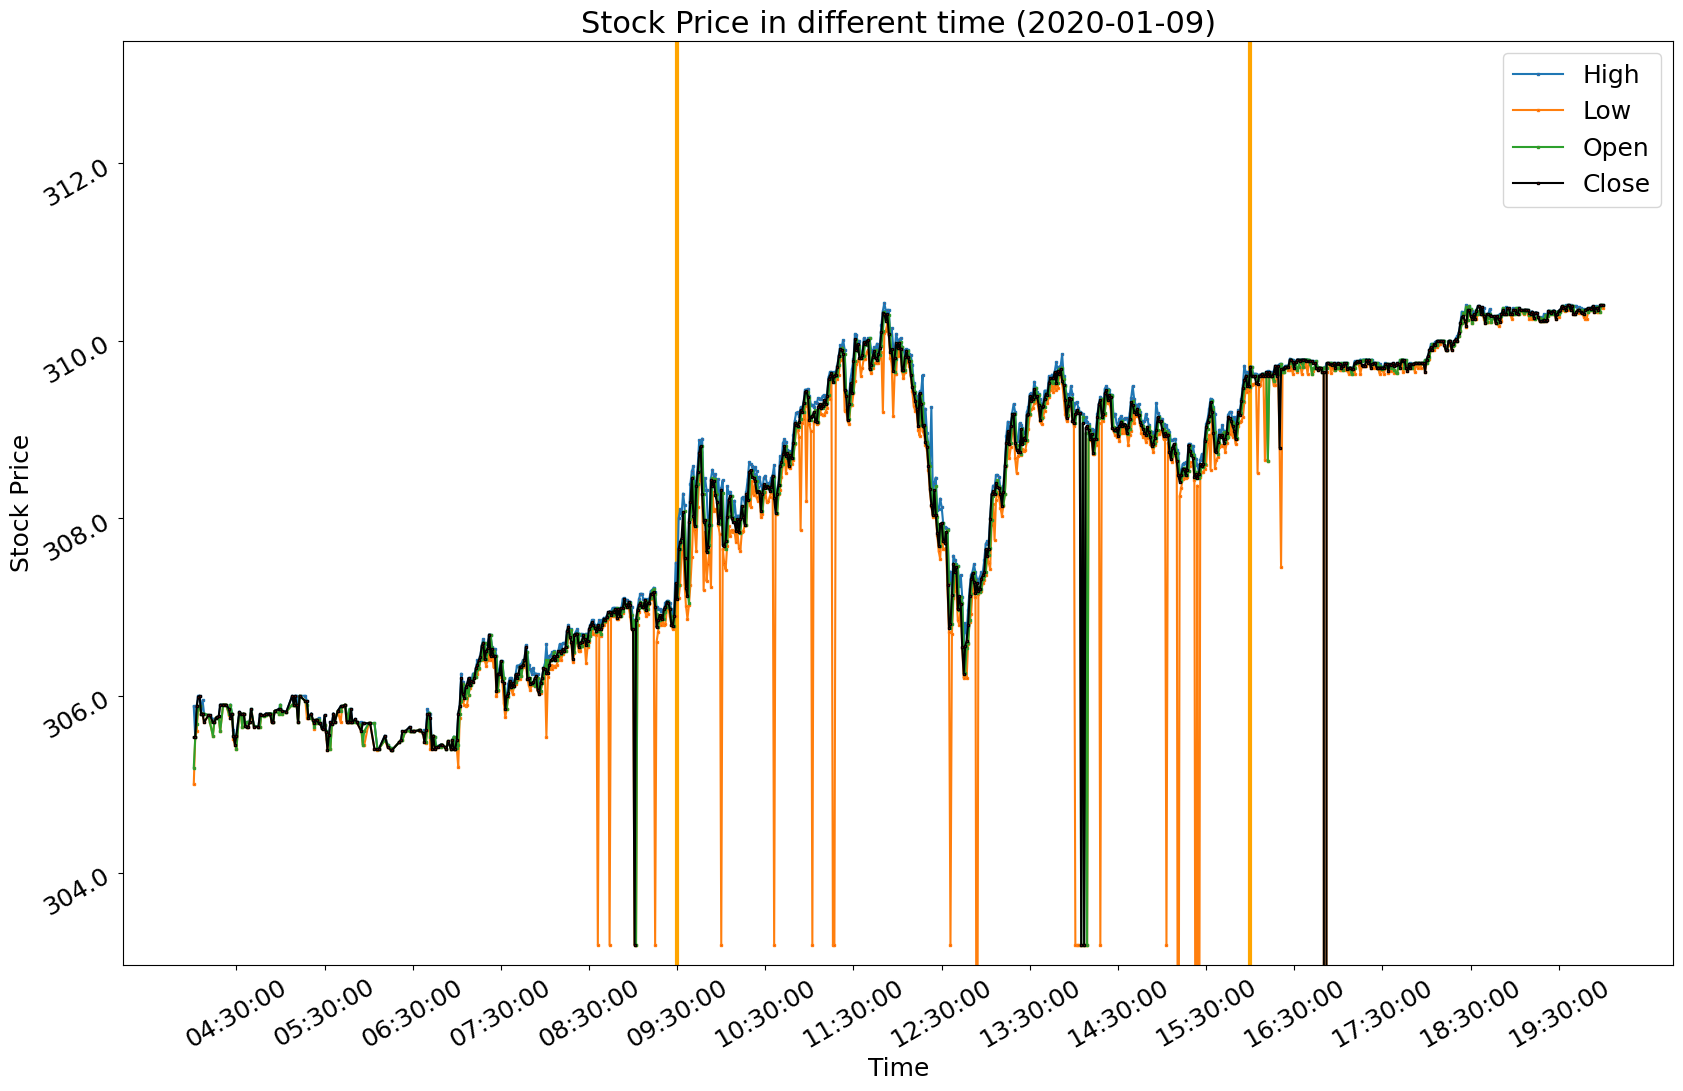

In [ ]:
price_plot(price_30min)
price_plot(price_5min)
price_plot(price_1min)

## Price Data pre-processing

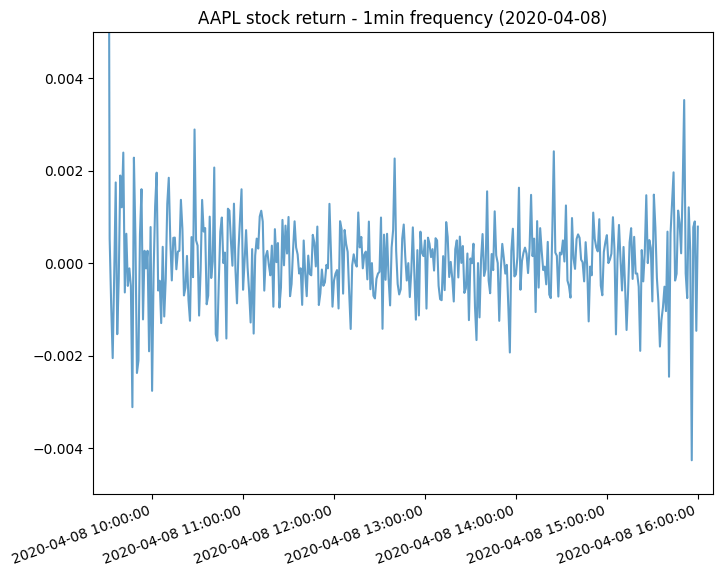

In [ ]:
selec_date = "04-08"
return_d = log_returns[pd.Series(log_returns.index, index = log_returns.index).apply(lambda x: x[5:10] == selec_date)]

fig = plt.figure(figsize=(8, 6));
ax1 = fig.add_subplot(1, 1, 1);
ax1.plot(return_d.index, return_d.values, lw=1.5, alpha=0.7);
ax1.set_xlim(return_d.index[0], return_d.index[-1]);
ax1.set_xlim(ax1.get_xlim()[0] - 10, ax1.get_xlim()[1] + 10);

date_list = ['2020-' + selec_date + ' 10:00:00',
             '2020-' + selec_date + ' 11:00:00', '2020-' + selec_date + ' 12:00:00',
             '2020-' + selec_date + ' 13:00:00', '2020-' + selec_date + ' 14:00:00',
             '2020-' + selec_date + ' 15:00:00', '2020-' + selec_date + ' 16:00:00']
ax1.set_xticks(return_d.index[pd.Series(return_d.index).apply(lambda x: x in date_list).values]);
ax1.set_ylim(-0.005, 0.005)

plt.xticks(rotation=20, horizontalalignment="right");
plt.title("AAPL stock return - 1min frequency (2020-%s)" % selec_date);

In [ ]:
prices = pd.read_csv(data_path + "1min_prices.csv", index_col = "To_Time")
time_str = [i[11:] for i in prices[pd.Series(prices.index, index = prices.index).apply(lambda x: x[5:10] == "01-02").values].index]
date_str = sorted(list(set(pd.DataFrame(prices.index).applymap(lambda x: x[5:10]).values.flatten())))

In [ ]:
def combine(date, time):
    return "2020-" + date + " " + time


def fillna_df(prices, n = 390, time_str = time_str, date_str = date_str):
    df = pd.DataFrame([])
    for date in date_str:
        a = prices[pd.Series(prices.index, index = prices.index).apply(lambda x: x[5:10] == date).values]
        if a.shape[0] != n:
            b = pd.DataFrame([], index=[combine(date, time) for time in time_str])
            a = a.merge(b, how = "outer", left_index=True, right_index=True)[["High", "Low", "Open", "Close"]].interpolate(method = "linear")
        df = pd.concat([df, a])
    return df

In [ ]:
prices = fillna_df(prices)
adjust_close = prices["Close"].copy()
# Get the subscription prices
last_high, first_low = adjust_close[adjust_close > 200][-1], adjust_close[adjust_close < 200][0]
adjust_close[adjust_close > 200] = adjust_close[adjust_close > 200] / last_high * first_low

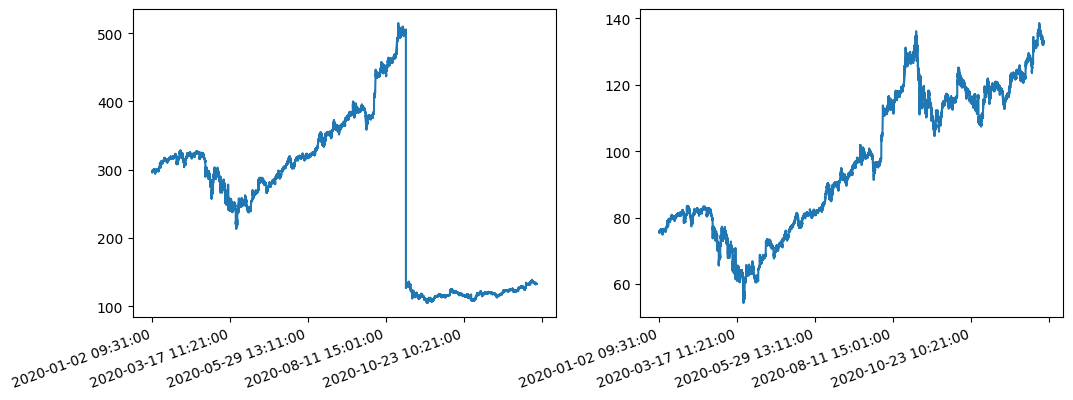

In [ ]:
fig = plt.figure(figsize=(12, 4));
ax1 = fig.add_subplot(1, 2, 1);
prices["Close"].plot(ax=ax1);
plt.xticks(rotation=20, horizontalalignment="right");

ax2 = fig.add_subplot(1, 2, 2);
adjust_close.plot(ax=ax2);
plt.xticks(rotation=20, horizontalalignment="right");

In [ ]:
log_returns = np.log((prices / prices.shift(1))["Close"].dropna())
# Smooth the immediate decrement due to split or dividend.
log_returns[log_returns.argmin()] = (log_returns[log_returns.argmin() - 1] + log_returns[log_returns.argmin() + 1]) / 2
log_returns

2020-01-02 09:32:00   -0.000728
2020-01-02 09:33:00    0.000677
2020-01-02 09:34:00    0.002904
2020-01-02 09:35:00    0.000944
2020-01-02 09:36:00    0.001376
                         ...   
2020-12-31 15:56:00    0.000377
2020-12-31 15:57:00    0.000974
2020-12-31 15:58:00    0.000570
2020-12-31 15:59:00    0.000151
2020-12-31 16:00:00   -0.002147
Name: Close, Length: 98669, dtype: float64